<a href="https://colab.research.google.com/github/sayakpaul/Adaptive-Gradient-Clipping/blob/main/BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import os
import urllib
from getpass import getpass

user = input('User name: ')
password = getpass('Password: ')
password = urllib.parse.quote(password)
repo_address = input('Repo Address: ')
branch_name = input('Branch name: ')

cmd_string = 'git clone https://{}:{}@github.com/{}.git -b {}'.format(
    user, password, repo_address, branch_name
)

os.system(cmd_string)
cmd_string, password = "", ""

User name: sayakpaul
Password: ··········
Repo Address: sayakpaul/Adaptive-Gradient-Clipping
Branch name: main


In [2]:
import sys
sys.path.append("Adaptive-Gradient-Clipping")

In [3]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.4.1


In [4]:
try: # detect TPUs
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.119.76.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.76.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [5]:
import agc
import dataloader
import models
import time
import utils

## Load flowers dataset

In [6]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
train_filenames, valid_filenames, train_steps = dataloader.create_steps(batch_size=BATCH_SIZE, validation_split=0.15)
print(f"Total training samples: {dataloader.count_data_items(train_filenames)}")
print(f"Total validation samples: {dataloader.count_data_items(valid_filenames)}")
print(f"Global batch size: {BATCH_SIZE}")

Total training samples: 3220
Total validation samples: 450
Global batch size: 512


In [7]:
train_ds = dataloader.get_training_dataset(batch_size=BATCH_SIZE, filenames=train_filenames)
validation_ds = dataloader.get_validation_dataset(batch_size=BATCH_SIZE, filenames=valid_filenames)
samples_images, sample_labels = next(iter(train_ds))
print(samples_images.shape, sample_labels.shape)

(512, 96, 96, 3) (512, 5)


## Compile model and define training callbacks

In [9]:
with strategy.scope():
    model = models.get_mini_vgg(use_bn=True)

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
print(f"Total learnable parameters: {model.count_params()/1e6} M")

Total learnable parameters: 0.002309 M


In [10]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
]

## Model training and evaluation

In [11]:
start = time.time()
history = model.fit(train_ds,
                   steps_per_epoch=train_steps,
                   validation_data=validation_ds,
                   callbacks=train_callbacks,
                   epochs=100)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/100
6/6 [==============================] - 9s 864ms/step - loss: 1.5665 - accuracy: 0.2829 - val_loss: 1.5927 - val_accuracy: 0.2511
Epoch 2/100
6/6 [==============================] - 1s 262ms/step - loss: 1.4638 - accuracy: 0.3657 - val_loss: 1.5902 - val_accuracy: 0.3000
Epoch 3/100
6/6 [==============================] - 1s 280ms/step - loss: 1.4180 - accuracy: 0.3864 - val_loss: 1.5819 - val_accuracy: 0.3333
Epoch 4/100
6/6 [==============================] - 1s 264ms/step - loss: 1.3803 - accuracy: 0.4094 - val_loss: 1.5709 - val_accuracy: 0.3467
Epoch 5/100
6/6 [==============================] - 1s 256ms/step - loss: 1.3755 - accuracy: 0.4103 - val_loss: 1.5629 - val_accuracy: 0.3267
Epoch 6/100
6/6 [==============================] - 1s 254ms/step - loss: 1.3386 - accuracy: 0.4388 - val_loss: 1.5578 - val_accuracy: 0.3133
Epoch 7/100
6/6 [==============================] - 2s 322ms/step - loss: 1.3640 - accuracy: 0.4132 - val_loss: 1.5533 - val_accuracy: 0.3311
Epoch 8/100
6

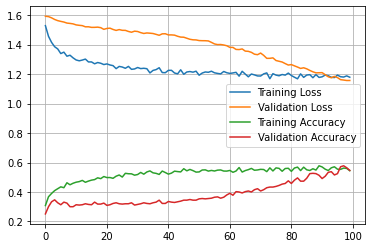

1/1 [==============================] - 1s 929ms/step - loss: 1.1566 - accuracy: 0.5467
Validation accuracy: 54.67%


In [12]:
utils.plot_history(history)
_, accuracy = model.evaluate(validation_ds)
print("Validation accuracy: {:.2f}%".format(accuracy*100))

Kindly keep in mind that the network is relatively very shallow.